In [1]:
import sys
import os

file_path = os.path.abspath('__file__')
print(file_path)
# file_path = 'c:\\Users\\RushiS\\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control'
# sys.path.append(file_path)
# sys.path.append(os.path.join(os.path.dirname(file_path), '../../'))
# sys.path.append(file_path)
import gym

from rl_gp_mpc.config_classes.visu_config import VisuConfig
from rl_gp_mpc.run_env_function import run_env
from examples.double_integrator.config_double_integrator import get_config

import torch
import matplotlib.pyplot as plt


c:\Users\RushiS\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control\examples\double_integrator\__file__


# Double Integrator Environment 

In [2]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import random
from os import path


class DoubIntEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 24
    }

    def __init__(self,m=1,c=0, target_state = np.array([[5],[0]])):

        self.m = m
        self.c = c

        self.dt = 0.1
        self.map_limit = 2
        self.dense_parameter = 20
        mapq, mapdq = np.meshgrid(np.linspace(-self.map_limit, self.map_limit, self.dense_parameter)
                                 , np.linspace(-self.map_limit, self.map_limit, self.dense_parameter))

        self.observation_space_low = np.array([-self.map_limit, -self.map_limit])
        self.observation_space_high = np.array([self.map_limit, self.map_limit])
        self.seed()
        self.viewer = None
        self.state = None
        self.ep_limit = 1000
        self.umin = -1.
        self.umax = 1.
        self.steps_beyond_done = None
        self.action_space = spaces.Box(low=np.array([self.umin]),
                               high=np.array([self.umax]),
                               dtype=np.float32)
        self.target_state = target_state
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_discrete(self, s):
        dis_state = (((s - self.observation_space_low)
                     /(self.observation_space_high - self.observation_space_low))
                    *self.dense_parameter)

        return dis_state.astype(np.int)

    def step(self, act):
        
        
        
        q, q_dot = self.state
        dt = self.dt
        u = act
        q = q + dt*q_dot
        q_dot = q_dot + q_dot*(-self.c/self.m) + (1/self.m)*dt*u
        self.last_u = u
        
        self.state = (np.array([q, q_dot[0]]))

        done = False

        # if (abs(q) <= 0.1) and (abs(q_dot) <= 0.1):
        #     cost = 10.0
        #     done = True
        
        # else:
        #     cost = -abs(q) - abs(q_dot)
        #     self.ep_count +=1

        if np.linalg.norm(self.target_state - self.state) <=0.1:
            done = True
            
        cost = -abs(q) - abs(q_dot)
        self.ep_count +=1

        if self.ep_count >= self.ep_limit:
            done = True

        if abs(q) >= (self.map_limit):
            cost = -abs(q) - abs(q_dot)
            done = True

        return np.array(self.state), cost, done, {}

    def reset(self):

        self.steps_beyond_done = None
        states = [np.array([self.map_limit - 0.1, 0])
                  , np.array([-self.map_limit + 0.1, 0])
                  ]
        # self.state = (random.choice(states))
        self.state = (np.array([-1,0]))
        self.ep_count = 0
        return np.array(self.state)
        

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.map_limit * 2
        scale = screen_width/world_width
        carty = 200  # TOP OF CART
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)

            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self.goal = rendering.Line((screen_width/2, 0), (screen_width, screen_height))
            self.goal.set_color(0, 0, 255)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

# Rollout

In [3]:
import os
import sys
file_path = os.path.abspath('__file__')
# print(file_path)
# file_path = 'c:\\Users\\RushiS\\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control'
# sys.path.append(file_path)
sys.path.append(os.path.join(os.path.dirname(file_path), '../../'))
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.models import PILCO
from examples.utils import rollout, policy

env = DoubIntEnv()

obs = env.reset()

X, Y = rollout(env=env, pilco=None, random=True, verbose = False,render=False, timesteps=100)
# print(X,Y)
for i in range(1, 10):
    X_, Y_ = rollout(env=env, pilco=None, random=True,verbose = False,render=False,  timesteps=100)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))
env.close()

state_dim = Y.shape[1]
control_dim = X.shape[1] - state_dim


Starting State:
 [-1  0]
Starting State:
 [-1  0]
Env Done... 28
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Env Done... 64
Starting State:
 [-1  0]
Env Done... 38
Starting State:
 [-1  0]
Env Done... 81
Starting State:
 [-1  0]
Env Done... 50
Starting State:
 [-1  0]
Env Done... 94
Starting State:
 [-1  0]
Env Done... 89


c:\Users\RushiS\anaconda3\envs\gp_rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Controller, Cost function and GP transition model

In [4]:
# path= "/mnt/c/Users/RushiS/OneDrive - Northeastern University/CS5180_RL/Project/PILCO-gpytorch"
import sys
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.rewards import ExponentialReward
from pilco.controllers import RbfController, LinearController


controller = RbfController(state_dim,control_dim,100,max_action = 1)
R = ExponentialReward(state_dim=state_dim,
                      t=np.array([5, 0]))

C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = Parameter(torch.tensor(Y).float().cuda(),requires_grad=True)


In [5]:
from rl_gp_mpc.control_objects.models.gp_model import GpStateTransitionModel
from rl_gp_mpc.config_classes.model_config import ModelConfig
model_config = ModelConfig(
		gp_init = {
            "noise_covar.noise": [1e-5, 1e-5],
            "base_kernel.lengthscale": [0.5, 0.5],
            "outputscale": [5e-2, 5e-2]
		},
		min_std_noise=1e-3,
		max_std_noise=1e-2,
		min_outputscale=1e-5,
		max_outputscale=0.95,
		min_lengthscale=4e-3,
		max_lengthscale=25.0,
		min_lengthscale_time=10,
		max_lengthscale_time=10000,
		init_lengthscale_time=100,
		include_time_model=False,
	)
transition_model = GpStateTransitionModel(config=model_config, 
                       dim_state=state_dim,
                       dim_action=control_dim)




In [6]:
#Debugging function in ~\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control\rl_gp_mpc\control_objects\models\gp_model.py:430, in calculate_factorizations(x, y, models)
#RuntimeError: Expected b and A to have the same dtype, but found b of type Float and A of type Double instead.
#iK = torch.cholesky_solve(batched_eye, L)
#batched_eye.dtype = float32
#L.dtpye = float64
def calculate_factorizations(x:torch.Tensor, y:torch.Tensor, models: "list[ExactGPModelMonoTask]"):
        """
        Compute iK and beta using the points in memory, which are needed to make predictions with the gaussian processes.
        These two variables only depends on data in memory, and not on input distribution,
        so they separated from other computation such that they can be computed outside the optimisation function,
        which is computed multiple times at each iteration

        Function inspired from
        https://github.com/nrontsis/PILCO/blob/6a962c8e4172f9e7f29ed6e373c4be2dd4b69cb7/pilco/models/mgpr.py#L81,
        reimplemented from tensorflow to pytorch
        Args:
            x (torch.Tensor): matrix containing the states and actions. Dim=(Nm, Ns + Na + Nc)
            y (torch.Tensor): matrix containing the states change. Dim=(Nm, Ns)
            models (list of gpytorch.models.ExactGP): list containing the gp models used to predict each state change.
                                                        Len=Ns
            Ns: number of states
            Na: number of actions
            Nc: number of context variables. At the moment, only 1 if time used
            Nm: number of points in memory

        Returns:
            iK (torch.Tensor): needed by the gaussian processes models to compute the predictions
            beta (torch.Tensor): needed by the gaussian processes models to compute the predictions

        """
        K = torch.stack([model.covar_module(x).evaluate() for model in models])
        batched_eye = torch.eye(K.shape[1]).repeat(K.shape[0], 1, 1).double()
        L = torch.linalg.cholesky(K + torch.stack([model.likelihood.noise for model in models])[:, None] * batched_eye)
        print(L.dtype)
        print(batched_eye.dtype)
        print(K.dtype)
        print(x.shape)
        print(K.shape)
        iK = torch.cholesky_solve(batched_eye, L)
        Y_ = (y.t())[:, :, None]
        beta = torch.cholesky_solve(Y_, L)[:, :, 0]
        return iK, beta
calculate_factorizations(torch.from_numpy(X),torch.from_numpy(Y),transition_model.models)

torch.float64
torch.float64
torch.float64
torch.Size([1000, 3])
torch.Size([2, 1000, 1000])


(tensor([[[ 9.8712e+04,  5.0150e+01,  1.5766e+01,  ...,  1.5687e+02,
           -1.9675e+01,  3.0360e+02],
          [ 5.0150e+01,  9.8461e+04,  1.5596e+02,  ..., -1.9008e+02,
            9.5719e+01,  4.7928e+00],
          [ 1.5766e+01,  1.5596e+02,  9.7424e+04,  ...,  4.5078e+01,
           -1.1080e+03, -1.3264e+01],
          ...,
          [ 1.5687e+02, -1.9008e+02,  4.5078e+01,  ...,  9.4396e+04,
           -2.6680e+01, -7.3594e+01],
          [-1.9675e+01,  9.5719e+01, -1.1080e+03,  ..., -2.6680e+01,
            9.6912e+04, -3.1449e+01],
          [ 3.0360e+02,  4.7928e+00, -1.3264e+01,  ..., -7.3594e+01,
           -3.1449e+01,  9.3717e+04]],
 
         [[ 9.8712e+04,  5.0150e+01,  1.5766e+01,  ...,  1.5687e+02,
           -1.9675e+01,  3.0360e+02],
          [ 5.0150e+01,  9.8461e+04,  1.5596e+02,  ..., -1.9008e+02,
            9.5719e+01,  4.7928e+00],
          [ 1.5766e+01,  1.5596e+02,  9.7424e+04,  ...,  4.5078e+01,
           -1.1080e+03, -1.3264e+01],
          ...,
    

In [5]:
from rl_gp_mpc.config_classes.training_config import TrainingConfig
training_config = TrainingConfig(
		lr_train=7e-3,
		iter_train=20,
		training_frequency=60,
		clip_grad_value=1e-3,
		print_train=True,
		step_print_train=1
	)
training_config.lr_train, 
training_config.iter_train, 
training_config.clip_grad_value,
training_config.print_train, 
training_config.step_print_train

1

# Optimizing GP model on experiences collected from Rollouts

In [6]:
transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))
saved_state = transition_model.save_state()
print(saved_state.to_tensors())
transition_model.train(saved_state,
                       training_config.lr_train, 
                        training_config.iter_train, 
                        training_config.clip_grad_value,
                        training_config.print_train, 
                        training_config.step_print_train)

NameError: name 'transition_model' is not defined

# Optimizing Controller 
* Evaluate Policy loss $J^{\pi}(\theta)$
* Minimize Policy loss by updating parameter $\theta$ using gradient computed by optimizer $\frac{dJ^{\pi}(\theta)}{d\theta}$

$J^{\pi}(\psi) = \sum_{t=0}^{T} \gamma^{t} \mathbb{E}_{x_t} [c(x_t)]$ 
 
where , 
* $\pi$ is a policy parametrized by $\theta$. We will choose a *RBF Network* to represent the policy or controller.
* $c(x_t) = 1 - exp(-\frac{1}{2\sigma_c^2} {||x - x_{target}||}^2)$. We will choose a *Exponentially Saturated* cost function $c(x_t) \in [0,1]$

$ \frac{dJ^{\pi}(\psi)}{d\psi} = \sum_{t=0}^{T} \frac{d}{d\psi} \mathbb{E}_{x_t} [c(x_t)]$ 

In [8]:
def prediction(env,controller,R,transition_model,m_init,S_init,len_horizon=100):


    dim_input_model = state_dim +control_dim 
    action = controller.compute_action(m_init,S_init)[0][0][0]
    # print(action)
    act_env = np.array([action.cpu().detach().numpy()])
    # print(action.cpu().detach().numpy())

    states_mu_pred = torch.empty((len_horizon + 1, len(m_init)))
    states_var_pred = torch.empty((len_horizon + 1, transition_model.dim_state, transition_model.dim_state))
    states_mu_pred[0] = m_init
    states_var_pred[0] = S_init

    # Rewards/Costs
    reward = torch.zeros(1).float().cuda()

    # Comparing result with actual environment
    X = []; Y = []
    x = env.reset()

    for idx_time in range(1, len_horizon + 1):
        # print("time step ",idx_time)
        action = controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
        
        input_mean = torch.empty((dim_input_model,))
        input_mean[:state_dim] = states_mu_pred[idx_time - 1]
        input_mean[state_dim:(state_dim + control_dim)] = action

        input_var = torch.zeros((dim_input_model, dim_input_model))
        input_var[:state_dim, :state_dim] = states_var_pred[idx_time - 1]

        state_change, state_change_var, v = transition_model.predict_next_state_change(input_mean.double(), input_var.double())
        # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

        states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
        states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                    input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                    v.t() @ input_var[:states_var_pred.shape[1]].t().double()
        
        # Cost Calculation for Trajectory
        reward = reward + R.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]
        # Comparing result with actual environment
        x_new, _, done, _ = env.step(act_env)
        X.append(np.hstack((x, act_env)))
        Y.append(x_new - x)
        x = x_new
    return states_mu_pred,states_var_pred,reward,X,Y



In [3]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        
        if step<=0:
            value = self.value_from
        elif step >= self.num_steps -1:
            value = self.value_to
        else:
            value = self.a*np.exp(self.b*(step))
        
        return value
    
num_episodes = 15
eps = ExponentialSchedule(1.5, 1e-2, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
lr.value(10)

0.015838196087665797

In [4]:
def env_rollout(env,controller,horizon):
    # Comparing result with actual environment
    X = []; Y = []
    x = env.reset()

    s = torch.zeros((len(x), len(x))).float().cuda()
    for idx_time in range(1, horizon + 1):
        # action = controller.compute_action(torch.from_numpy(x).float().cuda(),s)[0][0][0]
        action = controller(torch.from_numpy(x).reshape(1,2))
        # act_env = np.array([action.cpu().detach().numpy()])
        act_env = np.array([action.cpu().detach().item()])
        x_new, _, done, _ = env.step(act_env)
        
        X.append(np.hstack((x, act_env)))
        Y.append(x_new - x)
        x = x_new
    return X,Y

In [25]:
import sys
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.rewards import ExponentialReward
from pilco.controllers import RbfController, LinearController
from rbf_layer import RBFLayer, l_norm, rbf_gaussian

from rl_gp_mpc.control_objects.models.gp_model import GpStateTransitionModel
from rl_gp_mpc.config_classes.model_config import ModelConfig
from rl_gp_mpc.config_classes.training_config import TrainingConfig


class PILCO(torch.nn.Module):
    def __init__(self, X, Y, num_induced_points=None, horizon=50, controller=None,
                reward=None, m_init=None, S_init=None, name=None, model_config: ModelConfig = None,
                training_config:TrainingConfig = None):
        super(PILCO, self).__init__()
        self.X = X
        self.Y = Y
        self.state_dim = Y.shape[1]
        self.control_dim = X.shape[1] - Y.shape[1]
        self.transition_model = GpStateTransitionModel(config=model_config, 
                       dim_state=self.state_dim,
                       dim_action=self.control_dim)
        self.horizon = horizon
        self.training_config = training_config

        if controller is None:
            # self.controller = RbfController(self.state_dim,self.control_dim,100,max_action = 1)
            self.controller = RBFLayer(in_features_dim=self.state_dim,
                    num_kernels=100,
                    out_features_dim=self.control_dim,
                    radial_function=rbf_gaussian,
                    norm_function=l_norm,
                    normalization=True,
                    saturation="sine")
            # self.controller = LinearController(state_dim=self.state_dim, control_dim=self.control_dim)
        else:
            self.controller = controller

        if reward is None:
            self.reward = ExponentialReward(state_dim=self.state_dim,
                      W = np.diag((1,0)),
                      t=np.array([1, 0]))
            
        else:
            self.reward = reward

        if m_init is None or S_init is None:
            # If the user has not provided an initial state for the rollouts,
            # then define it as the first state in the dataset.
            self.m_init = X[0:1, 0:self.state_dim]
            self.S_init = np.diag(np.ones(self.state_dim) * 1e-6)
        else:
            self.m_init = m_init
            self.S_init = S_init
        self.optimizer = None
        self.best_reward = 0
        self.optimizer = None
        self.optim_lr = 1e-3
        self.best_loss = 0
        self.eps = 1e-2
        self.explore = -0.1
        self.gamma = 0.9
    
    def train(self):
        self.transition_model.prepare_inference(torch.from_numpy(self.X), torch.from_numpy(self.Y))
        saved_state = self.transition_model.save_state()
        self.transition_model.train(saved_state,
                            self.training_config.lr_train, 
                            self.training_config.iter_train, 
                            self.training_config.clip_grad_value,
                            self.training_config.print_train, 
                            self.training_config.step_print_train)
    
    def prediction(self,m_init,S_init):
        len_horizon=self.horizon
        self.transition_model.prepare_inference(torch.from_numpy(self.X), torch.from_numpy(self.Y))
        dim_input_model = self.state_dim +self.control_dim 
        # action = controller.compute_action(m_init,S_init)[0][0][0]
        # print(action)
        # act_env = np.array([action.cpu().detach().numpy()])
        # print(action.cpu().detach().numpy())

        states_mu_pred = torch.empty((len_horizon + 1, self.state_dim))
        # states_mu_pred.requires_grad = True
        states_var_pred = torch.empty((len_horizon + 1, self.state_dim, self.state_dim))
        # states_var_pred.requires_grad = True
        states_mu_pred[0] = m_init
        states_var_pred[0] = S_init

        # Rewards/Costs
        cost = torch.zeros(1).float().cuda()
        cost.requires_grad = True
       
        

        for idx_time in range(1, len_horizon + 1):
            
            # action = self.controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
            
            action = self.controller(states_mu_pred[idx_time - 1].reshape(1,self.state_dim))
            
            input_mean = torch.empty((dim_input_model,))
            input_mean[:self.state_dim] = states_mu_pred[idx_time - 1]
            input_mean[self.state_dim:(self.state_dim + self.control_dim)] = action
        
          
            input_var = torch.zeros((dim_input_model, dim_input_model))
            input_var[:self.state_dim, :self.state_dim] = states_var_pred[idx_time - 1]

            state_change, state_change_var, v = self.transition_model.predict_next_state_change(input_mean.double(), input_var.double())
            
            # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

            states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
            states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                        input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                        v.t() @ input_var[:states_var_pred.shape[1]].t().double()
            
           
            # Cost Calculation for Trajectory
            L,S = self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]
            

            cost = cost + self.gamma**(-(idx_time-1))*(L +self.explore*torch.sqrt(S))
            
        return states_mu_pred,states_var_pred,cost
    
    def optimize_policy(self):
        maxiter = 12
        if self.optimizer is None:
            optimizer = torch.optim.Adam([
                            {'params':self.controller.parameters()},
                            ], lr=self.optim_lr)
        
            self.optimizer = optimizer
        
        self.optimizer.param_groups[0]['lr'] = self.optim_lr
        m_init = torch.from_numpy(self.m_init).cuda()
        S_init = torch.from_numpy(self.S_init).cuda()
        cost = torch.zeros(1).float().cuda()
        
        losses = []
        
        for i in range(maxiter):
                    self.optimizer.zero_grad()
                    states_mu_pred,states_var_pred,cost = self.prediction(m_init,S_init)
                    # states_mu_pred = states_mu_pred.detach();states_var_pred= states_var_pred.detach()
                    
                    loss = cost
                    
                    loss.backward(retain_graph=False)
                    # plot_grad_flow_v2(self.controller.parameters())
                    print('(Optimize Policy: Iter %d/%d - Loss: %.3f )' % (i+1,maxiter,loss.item()))
                    self.optimizer.step()
                    losses.append(loss.item())
        return losses
    def add(self,X,Y):
        self.X = np.vstack((self.X, X))
        self.Y = np.vstack((self.Y, Y))

In [26]:
from examples.utils import rollout, policy
env = DoubIntEnv()

model_config = ModelConfig(
		gp_init = {
            "noise_covar.noise": [1e-5, 1e-5],
            "base_kernel.lengthscale": [0.5, 0.5],
            "outputscale": [5e-2, 5e-2]
			# "noise_covar.noise": [1e-5],
            # "base_kernel.lengthscale": [0.5],
            # "outputscale": [5e-2]
		},
		min_std_noise=1e-3,
		max_std_noise=1e-2,
		min_outputscale=1e-5,
		max_outputscale=0.95,
		min_lengthscale=4e-3,
		max_lengthscale=25.0,
		min_lengthscale_time=10,
		max_lengthscale_time=10000,
		init_lengthscale_time=100,
		include_time_model=False,
	)
training_config = TrainingConfig(
		lr_train=7e-3,
		iter_train=20,
		training_frequency=60,
		clip_grad_value=1e-3,
		print_train=False,
		step_print_train=10
	)
X, Y = rollout(env=env, pilco=None, random=True, verbose = False,render=False, timesteps=100)
# print(X,Y)
for i in range(1, 10):
    X_, Y_ = rollout(env=env, pilco=None, random=True,verbose = False,render=False,  timesteps=100)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))
env.close()
pilco = PILCO(X,Y,model_config=model_config,training_config=training_config,horizon=50)
pilco.controller.umax = 1
pilco.optim_lr = 5e-2
pilco.train()
# pilco.controller.randomize()
# pilco.optimize_policy()

c:\Users\RushiS\anaconda3\envs\gp_rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Starting State:
 [-1  0]
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Env Done... 45
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Env Done... 70
Starting State:
 [-1  0]
Env Done... 24
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Starting State:
 [-1  0]
Env Done... 65
Starting State:
 [-1  0]
Env Done... 59
training process - model 0 - time train 14.200026 - output_scale: 0.037305202 - lengthscales: [[25.     5.777 25.   ]] - noise: [0.]
training process - model 1 - time train 31.143686 - output_scale: 0.13374391 - lengthscales: [[25.    25.    11.161]] - noise: [0.]
training process - previous marginal log likelihood: [-4.042 -4.041] - new marginal log likelihood: [-5.937 -5.932]


In [13]:
from torch.nn import Module,Parameter
state_dim = 2
control_dim = 1
m_init = np.array([0,0])
S_init = np.diag(np.ones(state_dim) * 1e-6)
m_init = torch.from_numpy(m_init).cuda()
S_init = torch.from_numpy(S_init).cuda()
len_horizon=22

pilco.transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))

dim_input_model = state_dim +control_dim 


states_mu_pred = torch.empty((len_horizon + 1, state_dim)).cuda()
# states_mu_pred.requires_grad = True
states_var_pred = torch.empty((len_horizon + 1, state_dim, state_dim)).cuda()
# states_var_pred.requires_grad = True
states_mu_pred[0] = m_init
states_var_pred[0] = S_init

# Rewards/Costs
cost = torch.zeros(1).float().cuda()
cost.requires_grad = True

W = Parameter(torch.tensor(np.eye(state_dim)), requires_grad=True).float().cuda()
t = torch.tensor(np.zeros((1, 2)), requires_grad=True).float().cuda()

m,S = states_mu_pred[0], states_var_pred[0]


#LOSS
SW = S @ W

iSpW = W / torch.det(torch.eye(state_dim, dtype=torch.float32).cuda()  + SW)

L = 1 -torch.exp(-(m-t) @ iSpW @ torch.t(m-t)/2)/ \
                torch.sqrt(torch.det(torch.eye(state_dim, dtype=torch.float32).cuda() + SW))

L

tensor([[9.5367e-07]], device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
state_dim = 2
control_dim = 1
m_init = X[0:1, 0:state_dim]
S_init = np.diag(np.ones(state_dim) * 1e-6)
len_horizon=22

pilco.transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))

dim_input_model = state_dim +control_dim 


states_mu_pred = torch.empty((len_horizon + 1, state_dim))
# states_mu_pred.requires_grad = True
states_var_pred = torch.empty((len_horizon + 1, state_dim, state_dim))
# states_var_pred.requires_grad = True
states_mu_pred[0] = m_init
states_var_pred[0] = S_init

# Rewards/Costs
cost = torch.zeros(1).float().cuda()
cost.requires_grad = True

W = Parameter(tensor(np.eye(state_dim)), requires_grad=True).float().cuda()
t = torch.tensor(np.zeros((1, 2)), requires_grad=True).float().cuda()


for idx_time in range(1, len_horizon + 1):
    # print("time step ",idx_time)
    action = controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
    
    input_mean = torch.empty((dim_input_model,))
    input_mean[:state_dim] = states_mu_pred[idx_time - 1]
    input_mean[state_dim:(state_dim + control_dim)] = action
    #free up space for cuda
    
    input_var = torch.zeros((dim_input_model, dim_input_model))
    input_var[:state_dim, :state_dim] = states_var_pred[idx_time - 1]

    state_change, state_change_var, v = pilco.transition_model.predict_next_state_change(input_mean.double(), input_var.double())
    
    # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

    states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
    states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                v.t() @ input_var[:states_var_pred.shape[1]].t().double()
    
    
    # Cost Calculation for Trajectory

    L,S, dLdm, dLds, dSdm, dSds = self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())
   

    cost = cost + self.gamma**(idx_time-1) *(L + self.explore*S)
    # cost = cost + self.gamma**(idx_time-1) *L 
# reward = reward + self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]


In [30]:
for name, param in pilco.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        print("Size ", param.shape)

controller.weights tensor([[ 0.0166,  0.1602,  0.1685, -0.0358,  0.1782, -0.0663,  0.0687,  0.1271,
         -0.1309,  0.2425, -0.2418, -0.1442, -0.1707, -0.1051,  0.1117, -0.0893,
         -0.1195,  0.0866, -0.2178, -0.0304,  0.1540, -0.2102, -0.0189, -0.2075,
          0.1926,  0.1030,  0.1145, -0.0271, -0.2150, -0.0883, -0.0408,  0.1833,
          0.1166, -0.0932,  0.0788, -0.1159,  0.0497, -0.0902,  0.0577, -0.1113,
          0.1139, -0.0370, -0.1292,  0.2371,  0.1619,  0.2113,  0.0968,  0.1755,
          0.0061, -0.0073, -0.0532,  0.1024,  0.1687, -0.1141,  0.1562, -0.0755,
          0.2160,  0.2435,  0.0516,  0.0304,  0.2286,  0.0916, -0.1604, -0.1935,
          0.0072,  0.0888, -0.1294, -0.1647,  0.1045,  0.0320, -0.1376,  0.0361,
         -0.1305, -0.0830,  0.0072, -0.2098, -0.0751, -0.1793,  0.1127, -0.0717,
          0.0819, -0.1115,  0.0053,  0.0656,  0.1239,  0.0426, -0.1933, -0.0616,
          0.0169,  0.1886, -0.0380, -0.1179,  0.1586,  0.1061,  0.1780, -0.1610,
         

# Pre Train the RBF Controller using bang bang policy

In [8]:
u_bang_bang = np.genfromtxt('bang_bang_controller.csv', delimiter=',')
x_bang_bang = np.genfromtxt('bang_bang_states.csv', delimiter=',')

x_bang_bang = x_bang_bang[:,:-1].T
u_bang_bang =u_bang_bang[:,None]
num_basis = len(u_bang_bang)

print(np.shape(x_bang_bang))
print(np.shape(u_bang_bang))
print(num_basis)

# np.random.randn(num_basis_functions, state_dim),
# 0.1*np.random.randn(num_basis_functions, control_dim)

x_values = x_bang_bang
x_values = np.vstack((x_values,np.zeros(2)))
y_values = u_bang_bang 
y_values = np.vstack((y_values,np.zeros(1)))


train_x  = torch.from_numpy(x_values)
x = train_x
train_y = torch.from_numpy(y_values)

(20, 2)
(20, 1)
20


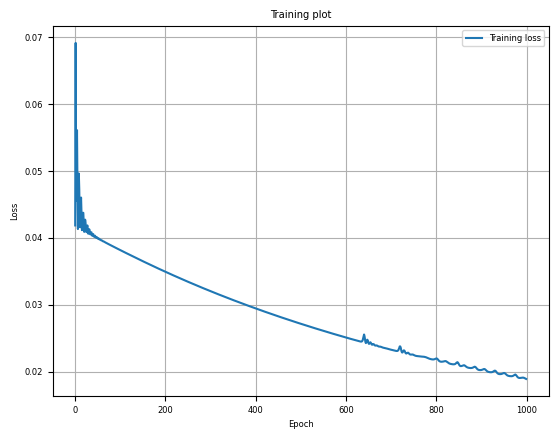

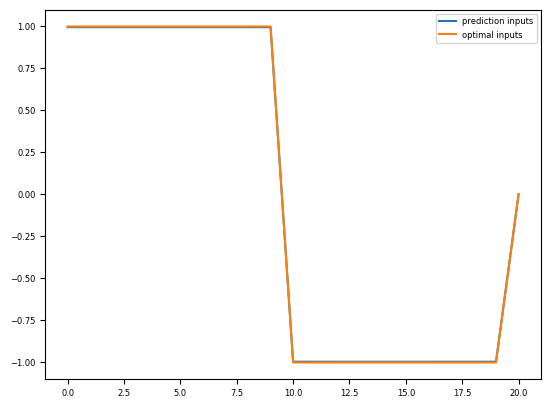

In [13]:
optimiser = torch.optim.Adam(pilco.controller.parameters(), lr=1e-3)
epoch = 0
batch_size = 32
trn_losses = []


for epoch in range(1000):
    epoch_trn_losses = []

    # Compute loss
    optimiser.zero_grad()
    y = pilco.controller(x)
    loss = torch.linalg.vector_norm(y-train_y)
    epoch_trn_losses.append(loss.item())
    loss.backward()
    optimiser.step()
    trn_losses.append(np.mean(epoch_trn_losses))
   

plt.plot(trn_losses, label='Training loss')
plt.legend()
plt.grid()
plt.title('Training plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(pilco.controller(x).detach(),label='prediction inputs')
plt.plot(y_values,label='optimal inputs')
plt.legend()
plt.show()

# Initialize the controller weights

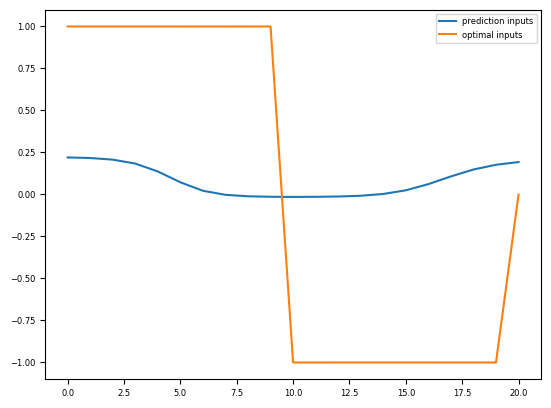

In [145]:
pilco.controller.reset(upper_bound_kernels=10,
                       std_shapes = 0.1,
                       gain_weights =1)
plt.plot(pilco.controller(x).detach(),label='prediction inputs')
plt.plot(y_values,label='optimal inputs')
plt.legend()
plt.show()

In [146]:
X,Y = env_rollout(env,pilco.controller,horizon=50)
pilco.add(X,Y)
pilco.train()

training process - model 0 - time train 11.695161 - output_scale: 0.23827162 - lengthscales: [[ 3.744  0.667 23.147]] - noise: [0.]
training process - model 1 - time train 13.024908 - output_scale: 0.5883916 - lengthscales: [[ 5.15   4.038 12.841]] - noise: [0.]
training process - previous marginal log likelihood: [-3.259 -3.234] - new marginal log likelihood: [-4.83 -4.91]


Iteration  1


C:\Users\RushiS\AppData\Local\Temp\ipykernel_23928\638831587.py:17: RuntimeWarning: divide by zero encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)
C:\Users\RushiS\AppData\Local\Temp\ipykernel_23928\638831587.py:17: RuntimeWarning: invalid value encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)


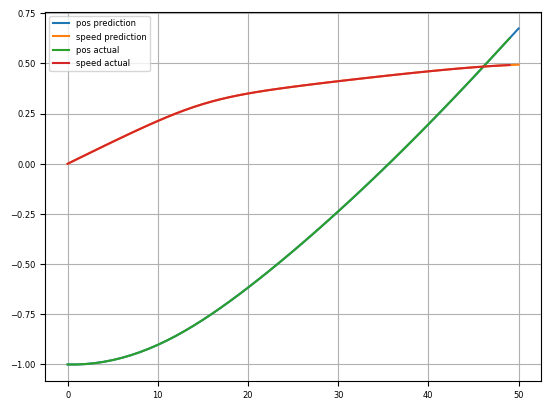

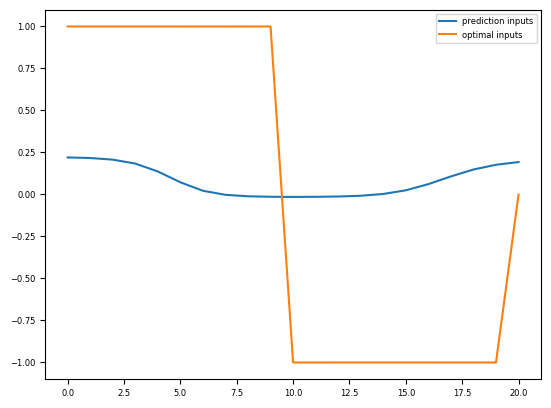

training process - model 0 - time train 5.525790 - output_scale: 0.7925407 - lengthscales: [[6.921 2.172 3.917]] - noise: [0.]
training process - model 1 - time train 12.075623 - output_scale: 0.06530409 - lengthscales: [[17.612  1.839  8.361]] - noise: [0.]
training process - previous marginal log likelihood: [-3.249 -3.249] - new marginal log likelihood: [-4.012 -4.139]
(Optimize Policy: Iter 1/12 - Loss: 170.383 )
(Optimize Policy: Iter 2/12 - Loss: 389.980 )
(Optimize Policy: Iter 3/12 - Loss: 117.131 )
(Optimize Policy: Iter 4/12 - Loss: 145.286 )
(Optimize Policy: Iter 5/12 - Loss: 164.957 )
(Optimize Policy: Iter 6/12 - Loss: 51.419 )
(Optimize Policy: Iter 7/12 - Loss: 150.908 )
(Optimize Policy: Iter 8/12 - Loss: 81.495 )
(Optimize Policy: Iter 9/12 - Loss: 49.925 )
(Optimize Policy: Iter 10/12 - Loss: 96.558 )
(Optimize Policy: Iter 11/12 - Loss: 74.719 )
(Optimize Policy: Iter 12/12 - Loss: 49.487 )


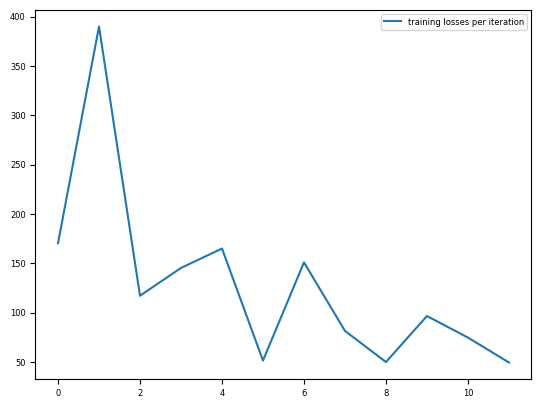

Iteration  2


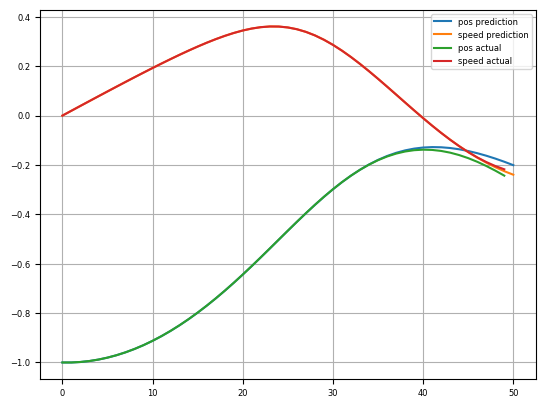

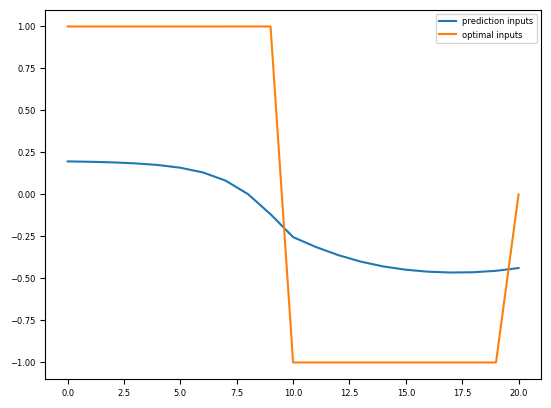

training process - model 0 - time train 5.129900 - output_scale: 0.7177699 - lengthscales: [[20.617  8.612  2.882]] - noise: [0.]
training process - model 1 - time train 8.253800 - output_scale: 0.5360438 - lengthscales: [[ 2.361  6.651 13.67 ]] - noise: [0.]
training process - previous marginal log likelihood: [-3.263 -3.281] - new marginal log likelihood: [-3.937 -3.728]
(Optimize Policy: Iter 1/12 - Loss: 60.408 )
(Optimize Policy: Iter 2/12 - Loss: 58.346 )
(Optimize Policy: Iter 3/12 - Loss: 30.953 )
(Optimize Policy: Iter 4/12 - Loss: 43.476 )
(Optimize Policy: Iter 5/12 - Loss: 54.744 )
(Optimize Policy: Iter 6/12 - Loss: 37.196 )
(Optimize Policy: Iter 7/12 - Loss: 31.679 )
(Optimize Policy: Iter 8/12 - Loss: 45.289 )
(Optimize Policy: Iter 9/12 - Loss: 41.452 )
(Optimize Policy: Iter 10/12 - Loss: 29.403 )
(Optimize Policy: Iter 11/12 - Loss: 35.027 )
(Optimize Policy: Iter 12/12 - Loss: 40.446 )


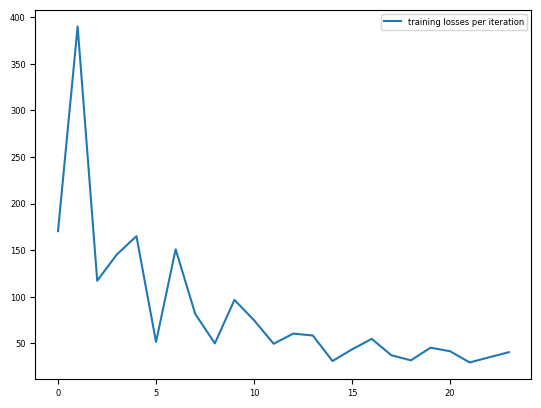

Iteration  3


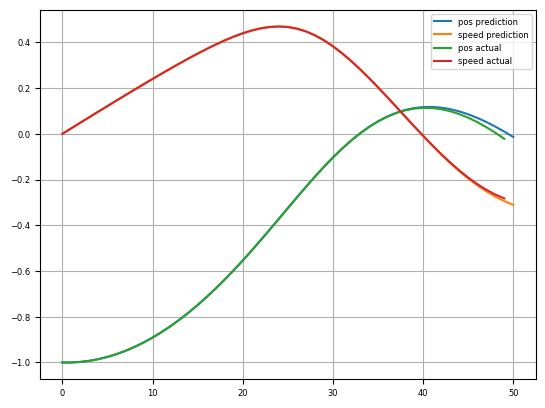

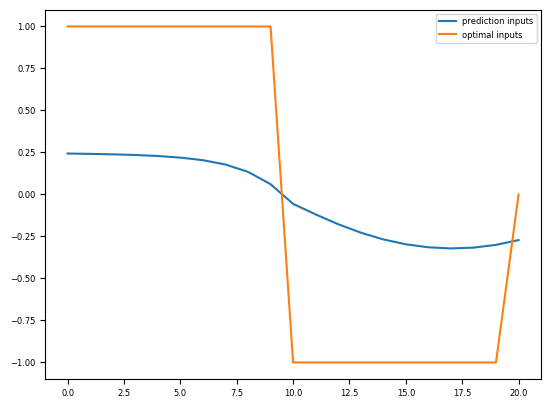

training process - model 0 - time train 5.198046 - output_scale: 0.75872207 - lengthscales: [[18.569 10.143 17.754]] - noise: [0.]
training process - model 1 - time train 12.209711 - output_scale: 0.59160745 - lengthscales: [[15.477 19.274  2.63 ]] - noise: [0.]
training process - previous marginal log likelihood: [-3.301 -3.293] - new marginal log likelihood: [-3.857 -4.514]
(Optimize Policy: Iter 1/12 - Loss: 26.101 )
(Optimize Policy: Iter 2/12 - Loss: 26.224 )
(Optimize Policy: Iter 3/12 - Loss: 29.250 )
(Optimize Policy: Iter 4/12 - Loss: 27.827 )
(Optimize Policy: Iter 5/12 - Loss: 24.520 )
(Optimize Policy: Iter 6/12 - Loss: 25.203 )
(Optimize Policy: Iter 7/12 - Loss: 27.035 )
(Optimize Policy: Iter 8/12 - Loss: 25.283 )
(Optimize Policy: Iter 9/12 - Loss: 23.631 )
(Optimize Policy: Iter 10/12 - Loss: 24.873 )
(Optimize Policy: Iter 11/12 - Loss: 25.511 )
(Optimize Policy: Iter 12/12 - Loss: 24.010 )


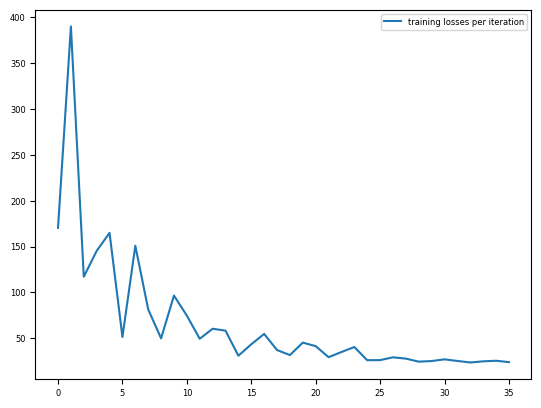

Iteration  4


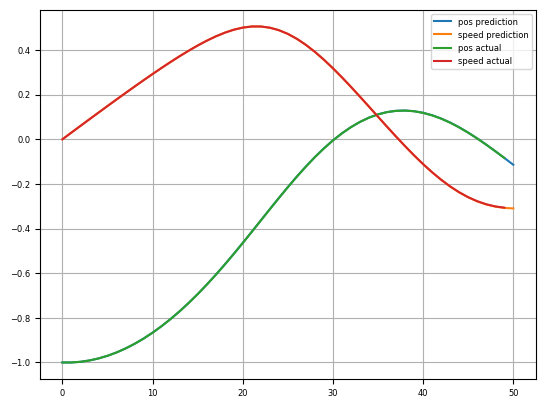

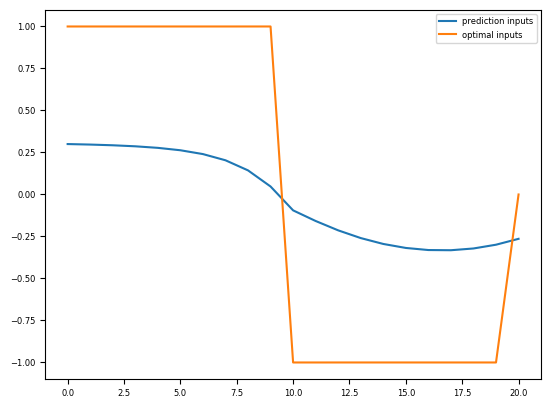

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 4.105947 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - model 1 - time train 9.981830 - output_scale: 0.5016945 - lengthscales: [[ 8.132 12.045  5.921]] - noise: [0.]
training process - previous marginal log likelihood: [-3.331 -3.239] - new marginal log likelihood: [-3.331 -3.955]
(Optimize Policy: Iter 1/12 - Loss: 23.199 )
(Optimize Policy: Iter 2/12 - Loss: 24.216 )
(Optimize Policy: Iter 3/12 - Loss: 24.181 )
(Optimize Policy: Iter 4/12 - Loss: 22.982 )
(Optimize Policy: Iter 5/12 - Loss: 22.936 )
(Optimize Policy: Iter 6/12 - Loss: 23.524 )
(Optimize Policy: Iter 7/12 - Loss: 23.098 )
(Optimize Policy: Iter 8/12 - Loss: 22.347 )
(Optimize Policy: Iter 9/12 - Loss: 22.511 )
(Optimize Policy: Iter 10/12 - Loss: 22.766 )
(Optimize Policy: Iter 11/12 - Loss: 22.244 )
(Optimize Policy: Iter 12/12 - Loss: 21.862 )


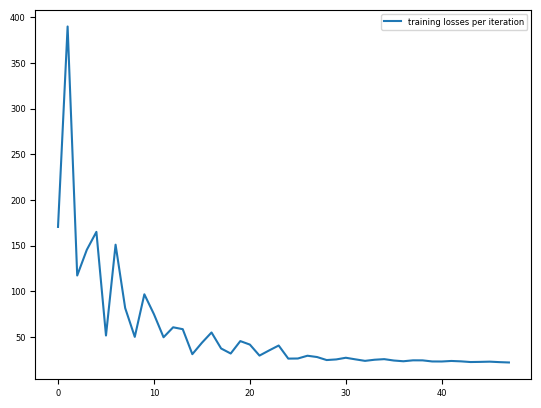

Iteration  5


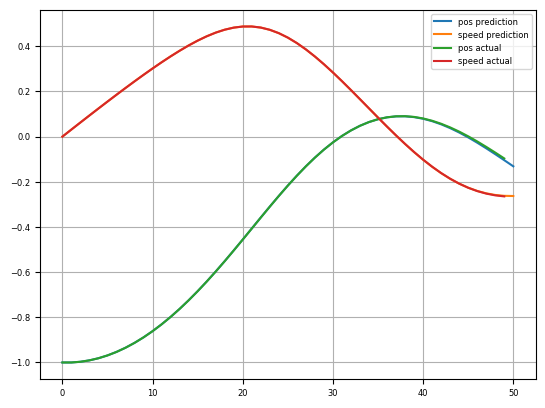

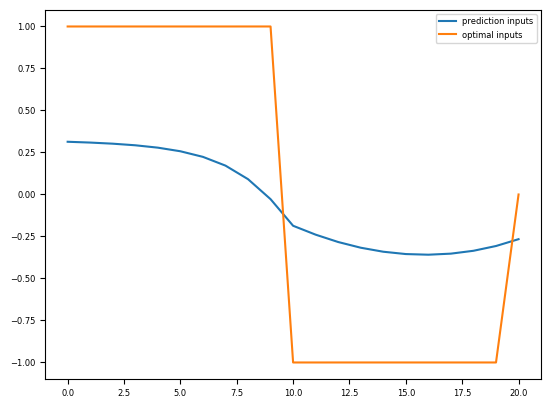

training process - model 0 - time train 7.728607 - output_scale: 0.4839049 - lengthscales: [[ 3.395  4.1   12.215]] - noise: [0.]
training process - model 1 - time train 12.767661 - output_scale: 0.65492356 - lengthscales: [[ 3.201  6.32  17.422]] - noise: [0.]
training process - previous marginal log likelihood: [-3.34  -3.306] - new marginal log likelihood: [-5.047 -4.813]
(Optimize Policy: Iter 1/12 - Loss: 21.607 )
(Optimize Policy: Iter 2/12 - Loss: 21.608 )
(Optimize Policy: Iter 3/12 - Loss: 21.223 )
(Optimize Policy: Iter 4/12 - Loss: 20.990 )
(Optimize Policy: Iter 5/12 - Loss: 21.047 )
(Optimize Policy: Iter 6/12 - Loss: 20.906 )
(Optimize Policy: Iter 7/12 - Loss: 20.574 )
(Optimize Policy: Iter 8/12 - Loss: 20.445 )
(Optimize Policy: Iter 9/12 - Loss: 20.407 )
(Optimize Policy: Iter 10/12 - Loss: 20.175 )
(Optimize Policy: Iter 11/12 - Loss: 19.922 )
(Optimize Policy: Iter 12/12 - Loss: 19.835 )


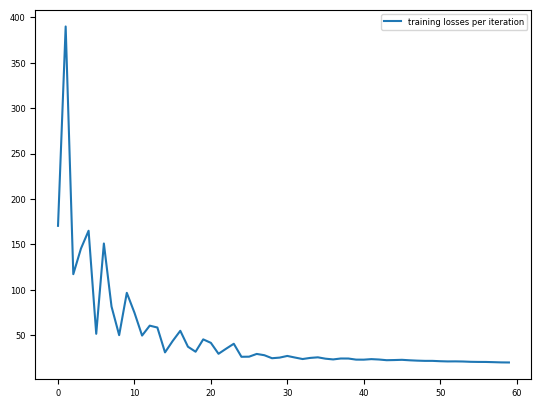

Iteration  6


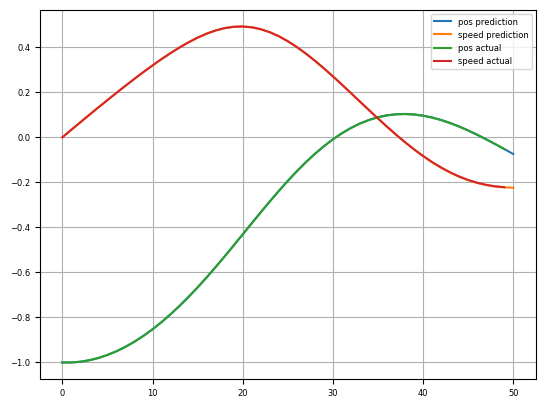

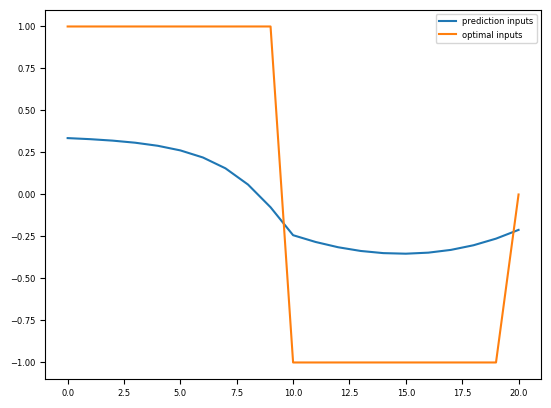

training process - model 0 - time train 8.033607 - output_scale: 0.6536779 - lengthscales: [[21.807  7.296  2.788]] - noise: [0.]
training process - model 1 - time train 11.098221 - output_scale: 0.68296844 - lengthscales: [[ 5.361 20.414 12.116]] - noise: [0.]
training process - previous marginal log likelihood: [-3.309 -3.325] - new marginal log likelihood: [-3.871 -3.72 ]
(Optimize Policy: Iter 1/12 - Loss: 19.619 )
(Optimize Policy: Iter 2/12 - Loss: 19.360 )
(Optimize Policy: Iter 3/12 - Loss: 19.146 )
(Optimize Policy: Iter 4/12 - Loss: 19.002 )
(Optimize Policy: Iter 5/12 - Loss: 18.787 )
(Optimize Policy: Iter 6/12 - Loss: 18.544 )
(Optimize Policy: Iter 7/12 - Loss: 18.380 )
(Optimize Policy: Iter 8/12 - Loss: 18.206 )
(Optimize Policy: Iter 9/12 - Loss: 17.959 )
(Optimize Policy: Iter 10/12 - Loss: 17.750 )
(Optimize Policy: Iter 11/12 - Loss: 17.580 )
(Optimize Policy: Iter 12/12 - Loss: 17.368 )


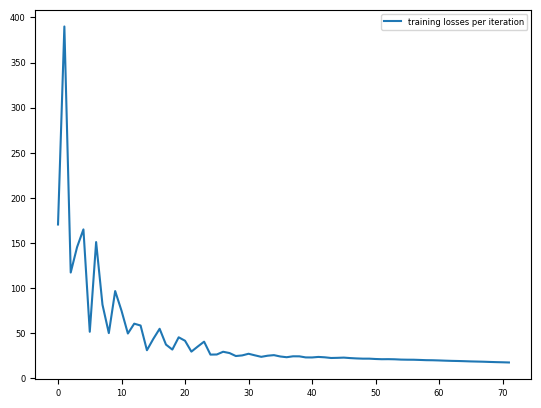

Iteration  7


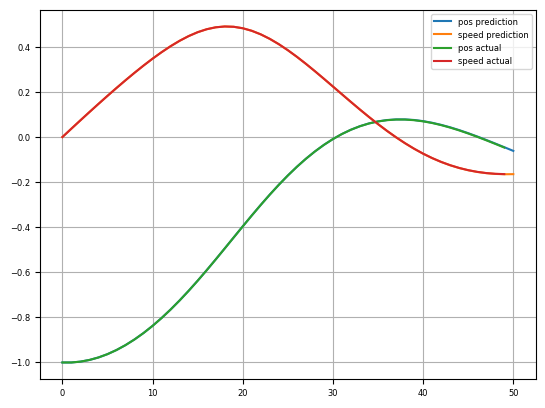

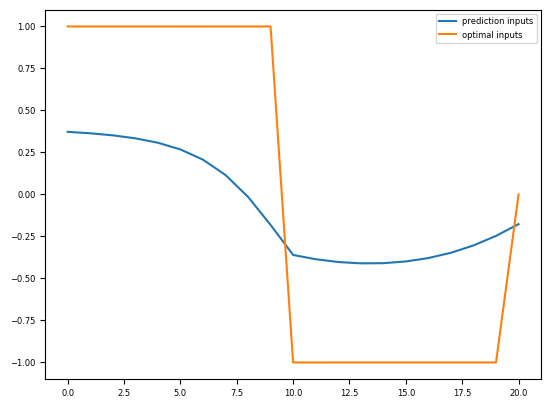

training process - model 0 - time train 7.092136 - output_scale: 0.44961205 - lengthscales: [[11.639 21.987 22.63 ]] - noise: [0.]
training process - model 1 - time train 13.363529 - output_scale: 0.86757517 - lengthscales: [[ 5.356 21.966 22.504]] - noise: [0.]
training process - previous marginal log likelihood: [-3.332 -3.31 ] - new marginal log likelihood: [-3.852 -4.186]
(Optimize Policy: Iter 1/12 - Loss: 17.130 )
(Optimize Policy: Iter 2/12 - Loss: 16.978 )
(Optimize Policy: Iter 3/12 - Loss: 16.790 )
(Optimize Policy: Iter 4/12 - Loss: 16.591 )
(Optimize Policy: Iter 5/12 - Loss: 16.441 )
(Optimize Policy: Iter 6/12 - Loss: 16.266 )
(Optimize Policy: Iter 7/12 - Loss: 16.095 )
(Optimize Policy: Iter 8/12 - Loss: 15.956 )
(Optimize Policy: Iter 9/12 - Loss: 15.785 )
(Optimize Policy: Iter 10/12 - Loss: 15.631 )
(Optimize Policy: Iter 11/12 - Loss: 15.490 )
(Optimize Policy: Iter 12/12 - Loss: 15.329 )


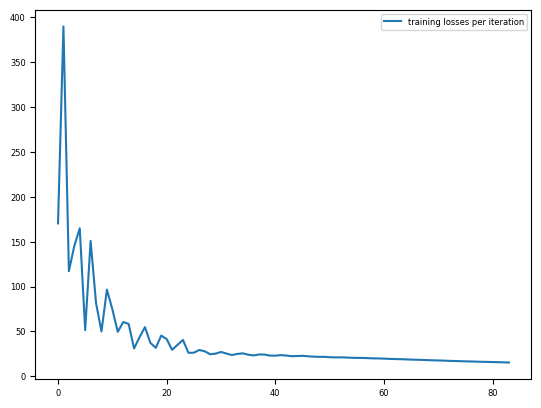

Iteration  8


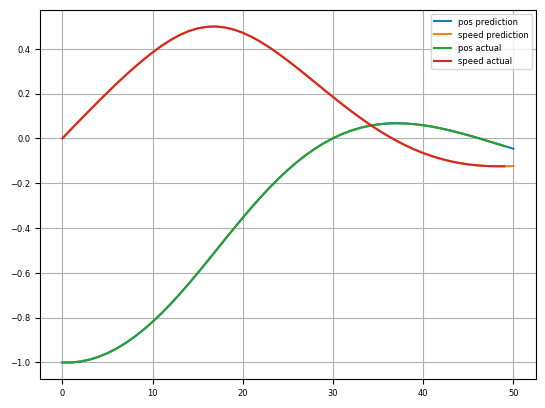

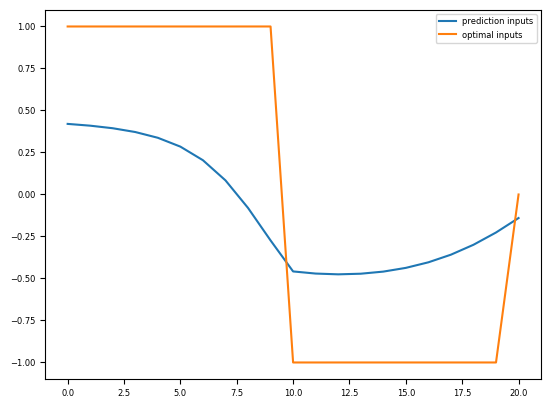

training process - model 0 - time train 9.070936 - output_scale: 0.8202219 - lengthscales: [[24.173 23.307 22.48 ]] - noise: [0.]
training process - model 1 - time train 14.872052 - output_scale: 0.88687575 - lengthscales: [[ 4.424 17.885  8.304]] - noise: [0.]
training process - previous marginal log likelihood: [-3.357 -3.318] - new marginal log likelihood: [-4.093 -4.164]
(Optimize Policy: Iter 1/12 - Loss: 15.148 )
(Optimize Policy: Iter 2/12 - Loss: 15.004 )
(Optimize Policy: Iter 3/12 - Loss: 14.853 )
(Optimize Policy: Iter 4/12 - Loss: 14.720 )
(Optimize Policy: Iter 5/12 - Loss: 14.575 )
(Optimize Policy: Iter 6/12 - Loss: 14.442 )
(Optimize Policy: Iter 7/12 - Loss: 14.309 )
(Optimize Policy: Iter 8/12 - Loss: 14.174 )
(Optimize Policy: Iter 9/12 - Loss: 14.050 )
(Optimize Policy: Iter 10/12 - Loss: 13.920 )
(Optimize Policy: Iter 11/12 - Loss: 13.800 )
(Optimize Policy: Iter 12/12 - Loss: 13.679 )


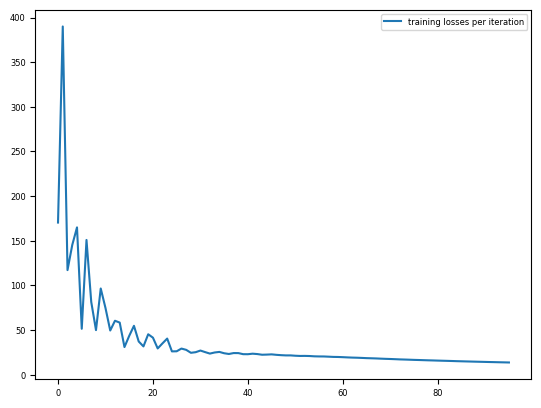

Iteration  9


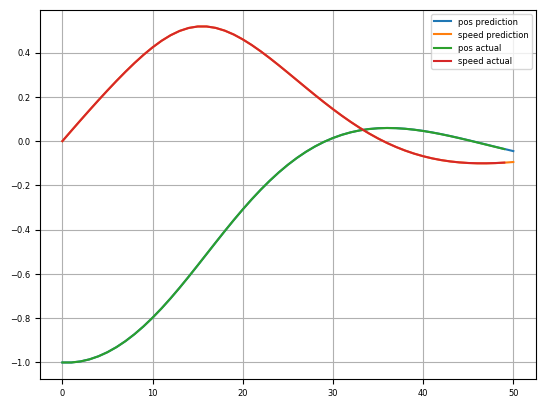

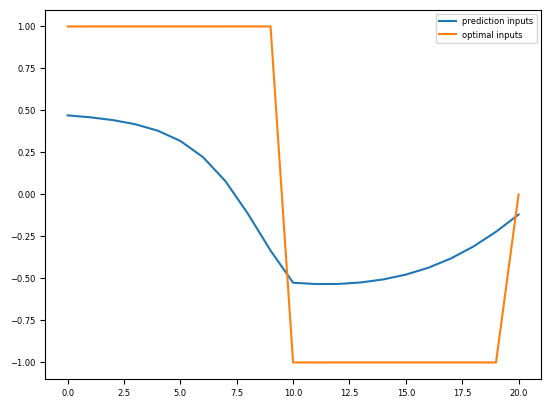

training process - model 0 - time train 4.130044 - output_scale: 0.56577003 - lengthscales: [[6.724 2.818 6.986]] - noise: [0.]
training process - model 1 - time train 13.497685 - output_scale: 0.3081859 - lengthscales: [[ 6.729 18.372  4.672]] - noise: [0.]
training process - previous marginal log likelihood: [-3.354 -3.318] - new marginal log likelihood: [-3.805 -4.443]
(Optimize Policy: Iter 1/12 - Loss: 13.508 )
(Optimize Policy: Iter 2/12 - Loss: 13.391 )
(Optimize Policy: Iter 3/12 - Loss: 13.275 )
(Optimize Policy: Iter 4/12 - Loss: 13.166 )
(Optimize Policy: Iter 5/12 - Loss: 13.054 )
(Optimize Policy: Iter 6/12 - Loss: 12.949 )
(Optimize Policy: Iter 7/12 - Loss: 12.844 )
(Optimize Policy: Iter 8/12 - Loss: 12.744 )
(Optimize Policy: Iter 9/12 - Loss: 12.646 )
(Optimize Policy: Iter 10/12 - Loss: 12.550 )
(Optimize Policy: Iter 11/12 - Loss: 12.458 )
(Optimize Policy: Iter 12/12 - Loss: 12.367 )


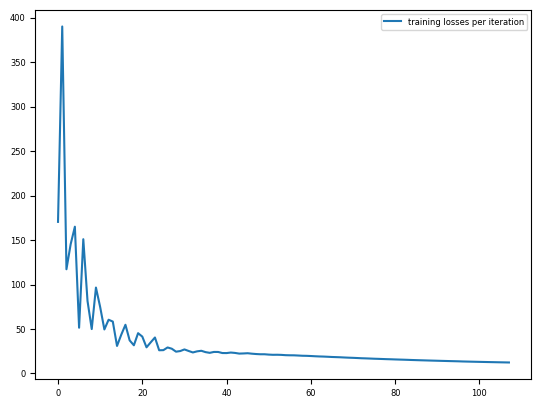

Iteration  10


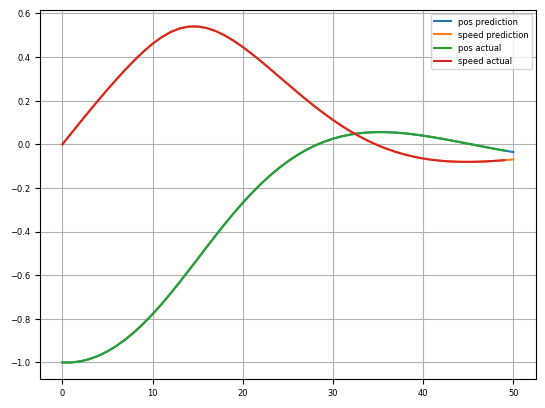

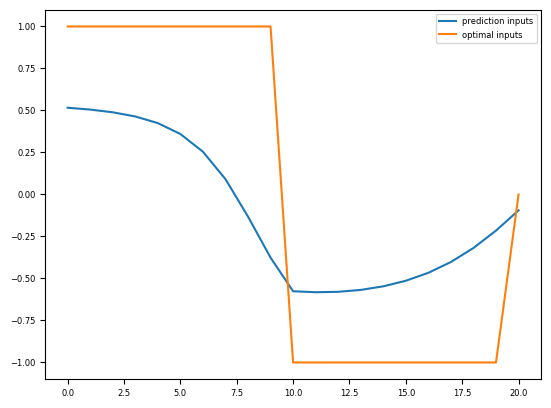

training process - model 0 - time train 6.451396 - output_scale: 0.56710017 - lengthscales: [[8.01  5.644 9.455]] - noise: [0.]
NaNs encountered when trying to perform matrix-vector multiplication
training process - model 1 - time train 12.939837 - output_scale: 0.89792055 - lengthscales: [[23.449 17.241  4.264]] - noise: [0.]
training process - previous marginal log likelihood: [-3.349 -3.348] - new marginal log likelihood: [-3.759 -4.19 ]
(Optimize Policy: Iter 1/12 - Loss: 12.205 )
(Optimize Policy: Iter 2/12 - Loss: 12.116 )
(Optimize Policy: Iter 3/12 - Loss: 12.031 )
(Optimize Policy: Iter 4/12 - Loss: 11.947 )
(Optimize Policy: Iter 5/12 - Loss: 11.866 )
(Optimize Policy: Iter 6/12 - Loss: 11.788 )
(Optimize Policy: Iter 7/12 - Loss: 11.712 )
(Optimize Policy: Iter 8/12 - Loss: 11.638 )
(Optimize Policy: Iter 9/12 - Loss: 11.567 )
(Optimize Policy: Iter 10/12 - Loss: 11.498 )
(Optimize Policy: Iter 11/12 - Loss: 11.431 )
(Optimize Policy: Iter 12/12 - Loss: 11.367 )


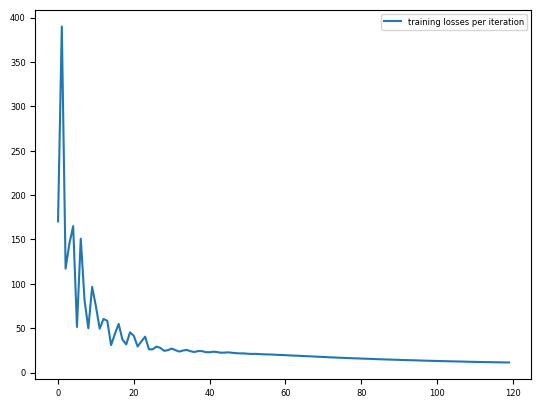

Iteration  11


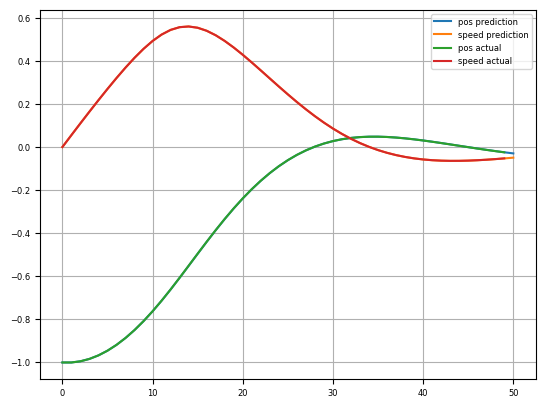

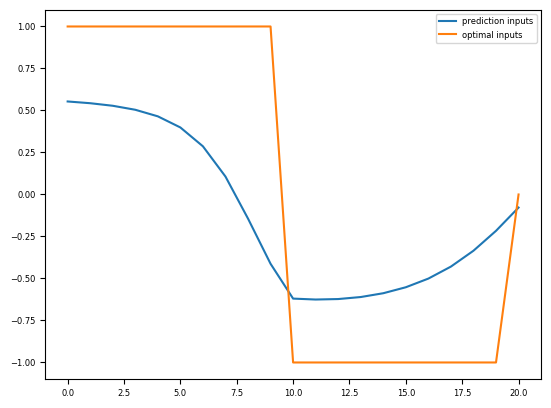

training process - model 0 - time train 9.851823 - output_scale: 0.3953551 - lengthscales: [[ 6.106 20.854 18.34 ]] - noise: [0.]
training process - model 1 - time train 13.124010 - output_scale: 0.6426457 - lengthscales: [[ 4.706  8.67  11.02 ]] - noise: [0.]
training process - previous marginal log likelihood: [-3.311 -3.324] - new marginal log likelihood: [-4.277 -3.705]
(Optimize Policy: Iter 1/12 - Loss: 11.218 )
(Optimize Policy: Iter 2/12 - Loss: 11.154 )
(Optimize Policy: Iter 3/12 - Loss: 11.093 )
(Optimize Policy: Iter 4/12 - Loss: 11.032 )
(Optimize Policy: Iter 5/12 - Loss: 10.975 )
(Optimize Policy: Iter 6/12 - Loss: 10.918 )
(Optimize Policy: Iter 7/12 - Loss: 10.864 )
(Optimize Policy: Iter 8/12 - Loss: 10.811 )
(Optimize Policy: Iter 9/12 - Loss: 10.761 )
(Optimize Policy: Iter 10/12 - Loss: 10.712 )
(Optimize Policy: Iter 11/12 - Loss: 10.665 )
(Optimize Policy: Iter 12/12 - Loss: 10.619 )


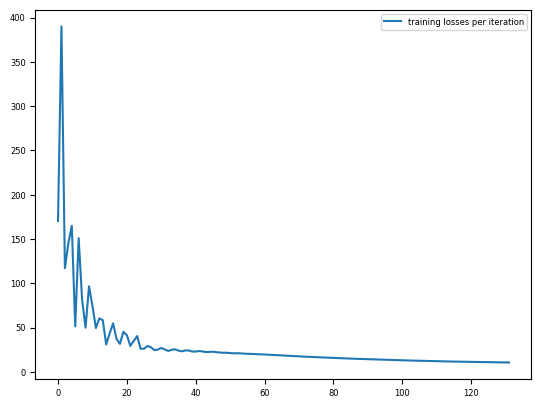

Iteration  12


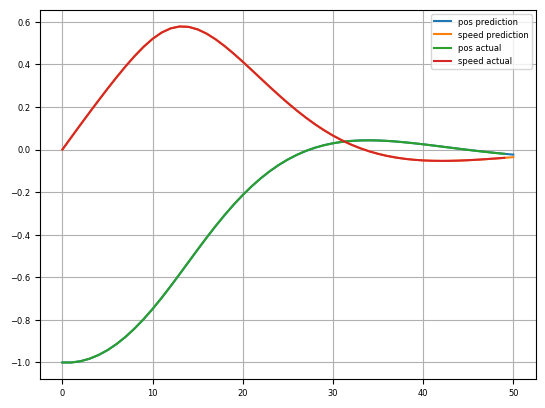

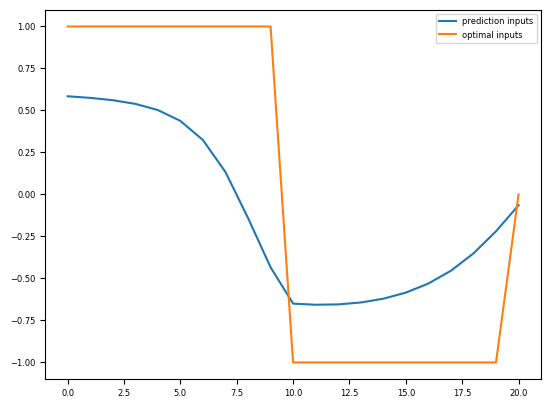

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 10.629412 - output_scale: 0.45467833 - lengthscales: [[12.377 16.837  2.449]] - noise: [0.]
training process - model 1 - time train 13.972111 - output_scale: 0.35368782 - lengthscales: [[19.767 13.115 14.507]] - noise: [0.]
training process - previous marginal log likelihood: [-3.407 -3.347] - new marginal log likelihood: [-4.711 -3.677]
(Optimize Policy: Iter 1/12 - Loss: 10.482 )
(Optimize Policy: Iter 2/12 - Loss: 10.436 )
(Optimize Policy: Iter 3/12 - Loss: 10.392 )
(Optimize Policy: Iter 4/12 - Loss: 10.348 )
(Optimize Policy: Iter 5/12 - Loss: 10.306 )
(Optimize Policy: Iter 6/12 - Loss: 10.266 )
(Optimize Policy: Iter 7/12 - Loss: 10.227 )
(Optimize Policy: Iter 8/12 - Loss: 10.189 )
(Optimize Policy: Iter 9/12 - Loss: 10.153 )
(Optimize Policy: Iter 10/12 - Loss: 10.118 )
(Optimize Policy: Iter 11/12 - Loss: 10.084 )
(Optimize Policy: Iter 12/12 - Loss: 10.052 )


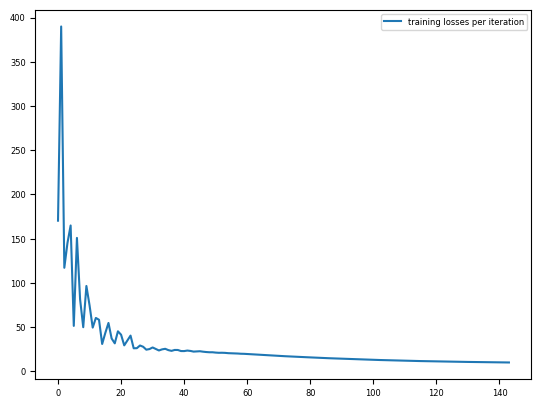

Iteration  13


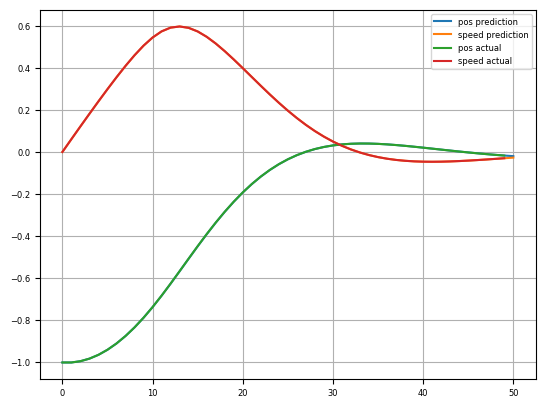

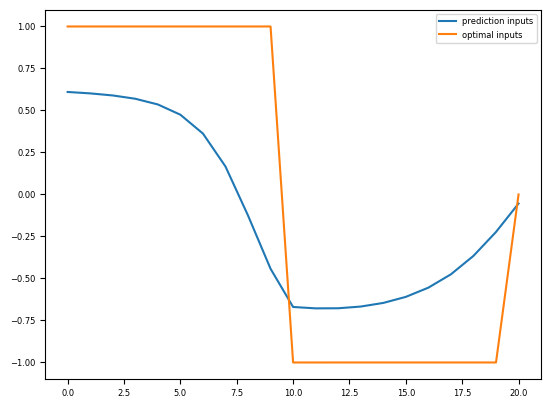

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 8.413666 - output_scale: 0.7896789 - lengthscales: [[20.945  9.329 19.138]] - noise: [0.]
training process - model 1 - time train 22.736951 - output_scale: 0.5590544 - lengthscales: [[22.852 11.332 18.194]] - noise: [0.]
training process - previous marginal log likelihood: [-3.33  -3.358] - new marginal log likelihood: [-3.893 -3.813]
(Optimize Policy: Iter 1/12 - Loss: 9.925 )
(Optimize Policy: Iter 2/12 - Loss: 9.891 )
(Optimize Policy: Iter 3/12 - Loss: 9.859 )
(Optimize Policy: Iter 4/12 - Loss: 9.827 )
(Optimize Policy: Iter 5/12 - Loss: 9.796 )
(Optimize Policy: Iter 6/12 - Loss: 9.766 )
(Optimize Policy: Iter 7/12 - Loss: 9.738 )
(Optimize Policy: Iter 8/12 - Loss: 9.710 )
(Optimize Policy: Iter 9/12 - Loss: 9.683 )
(Optimize Policy: Iter 10/12 - Loss: 9.657 )
(Optimize Policy: Iter 11/12 - Loss: 9.632 )
(Optimize Policy: Iter 12/12 - Loss: 9.608 )


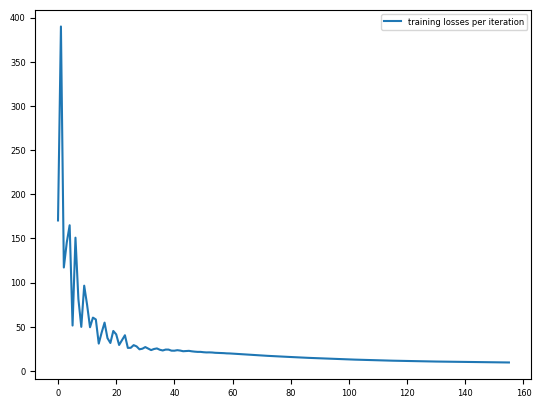

Iteration  14


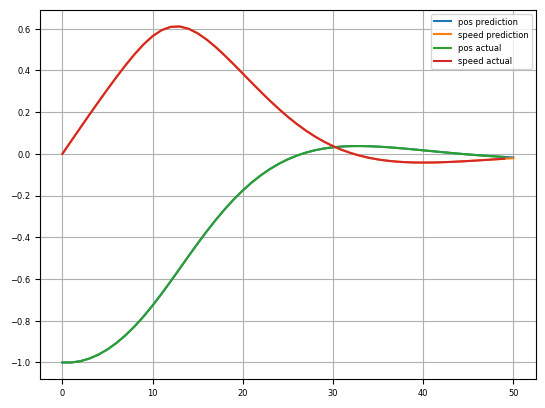

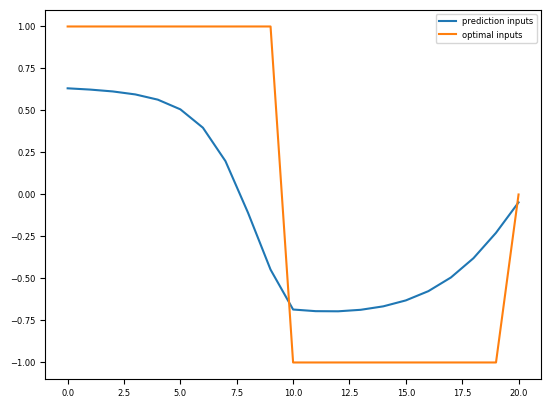

training process - model 0 - time train 24.223922 - output_scale: 0.078748964 - lengthscales: [[10.298 18.232 19.237]] - noise: [0.]
training process - model 1 - time train 42.480673 - output_scale: 0.015464932 - lengthscales: [[ 3.267  9.353 18.94 ]] - noise: [0.]
training process - previous marginal log likelihood: [-3.379 -3.357] - new marginal log likelihood: [-5.862 -5.665]
(Optimize Policy: Iter 1/12 - Loss: 9.494 )
(Optimize Policy: Iter 2/12 - Loss: 9.468 )
(Optimize Policy: Iter 3/12 - Loss: 9.444 )
(Optimize Policy: Iter 4/12 - Loss: 9.420 )
(Optimize Policy: Iter 5/12 - Loss: 9.396 )
(Optimize Policy: Iter 6/12 - Loss: 9.373 )
(Optimize Policy: Iter 7/12 - Loss: 9.352 )
(Optimize Policy: Iter 8/12 - Loss: 9.330 )
(Optimize Policy: Iter 9/12 - Loss: 9.310 )
(Optimize Policy: Iter 10/12 - Loss: 9.290 )
(Optimize Policy: Iter 11/12 - Loss: 9.270 )
(Optimize Policy: Iter 12/12 - Loss: 9.252 )


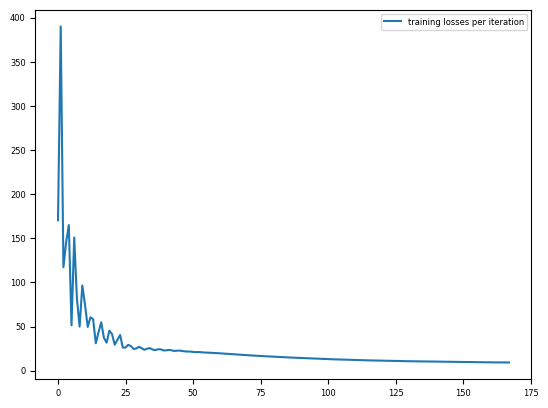

Iteration  15


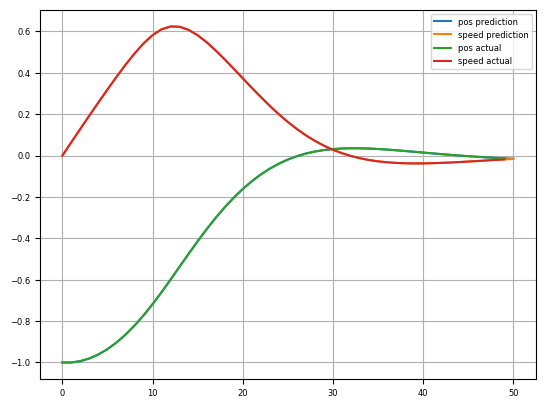

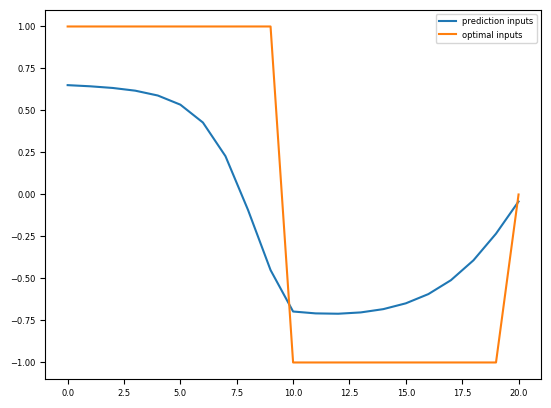

training process - model 0 - time train 14.775389 - output_scale: 0.20514381 - lengthscales: [[ 6.072  1.916 14.026]] - noise: [0.]
training process - model 1 - time train 22.336509 - output_scale: 0.6117828 - lengthscales: [[22.526 10.009 19.314]] - noise: [0.]
training process - previous marginal log likelihood: [-3.366 -3.37 ] - new marginal log likelihood: [-4.083 -3.728]
(Optimize Policy: Iter 1/12 - Loss: 9.150 )
(Optimize Policy: Iter 2/12 - Loss: 9.130 )
(Optimize Policy: Iter 3/12 - Loss: 9.111 )
(Optimize Policy: Iter 4/12 - Loss: 9.092 )
(Optimize Policy: Iter 5/12 - Loss: 9.074 )
(Optimize Policy: Iter 6/12 - Loss: 9.056 )
(Optimize Policy: Iter 7/12 - Loss: 9.039 )
(Optimize Policy: Iter 8/12 - Loss: 9.022 )
(Optimize Policy: Iter 9/12 - Loss: 9.006 )
(Optimize Policy: Iter 10/12 - Loss: 8.990 )
(Optimize Policy: Iter 11/12 - Loss: 8.975 )
(Optimize Policy: Iter 12/12 - Loss: 8.960 )


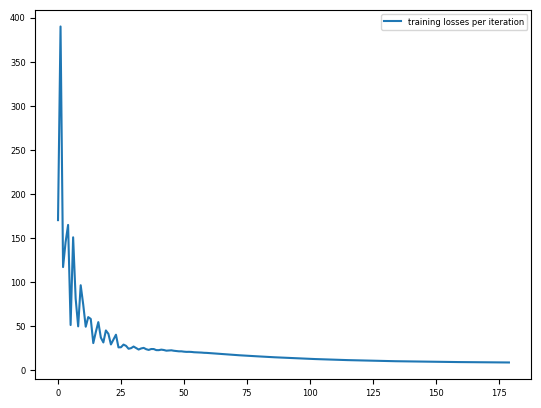

Iteration  16


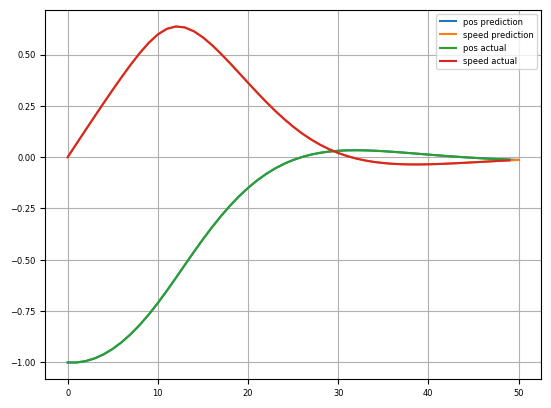

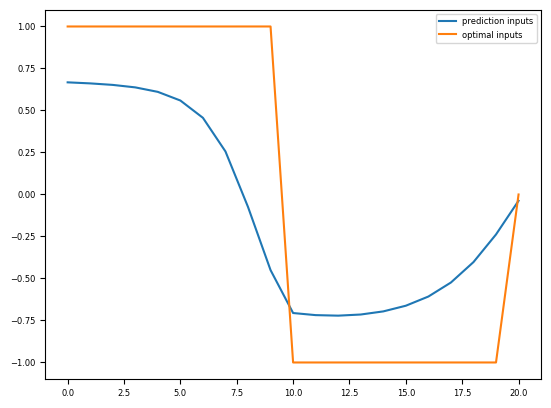

training process - model 0 - time train 10.653099 - output_scale: 0.47372842 - lengthscales: [[23.254 14.364 15.707]] - noise: [0.]
NaNs encountered when trying to perform matrix-vector multiplication
training process - model 1 - time train 20.849075 - output_scale: 0.4421614 - lengthscales: [[ 9.909 19.149 19.645]] - noise: [0.]
training process - previous marginal log likelihood: [-3.412 -3.391] - new marginal log likelihood: [-3.869 -3.902]
(Optimize Policy: Iter 1/12 - Loss: 8.869 )
(Optimize Policy: Iter 2/12 - Loss: 8.853 )
(Optimize Policy: Iter 3/12 - Loss: 8.837 )
(Optimize Policy: Iter 4/12 - Loss: 8.822 )
(Optimize Policy: Iter 5/12 - Loss: 8.808 )
(Optimize Policy: Iter 6/12 - Loss: 8.793 )
(Optimize Policy: Iter 7/12 - Loss: 8.779 )
(Optimize Policy: Iter 8/12 - Loss: 8.766 )
(Optimize Policy: Iter 9/12 - Loss: 8.753 )
(Optimize Policy: Iter 10/12 - Loss: 8.740 )
(Optimize Policy: Iter 11/12 - Loss: 8.728 )
(Optimize Policy: Iter 12/12 - Loss: 8.716 )


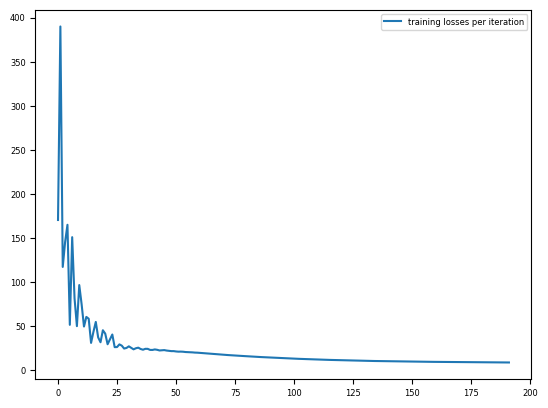

In [147]:



num_episodes = 15
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-1, 0, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
pilco.optim_lr = 5e-2
pilco.gamma = 0.9
losses = []
for _ in range(num_episodes+1):
    print("Iteration ",(_+1))
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    # pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()
    
    plt.title("Controller inputs along the optimum trajectory")
    plt.plot(pilco.controller(x).detach(),label='controller inputs')
    plt.plot(y_values,label='optimal inputs')
    plt.xlabel("Test inputs")
    plt.legend()
    plt.show()

    pilco.add(X,Y)
    pilco.train()

    # pilco.eps = eps.value(_) 
    # pilco.optim_lr = lr.value(_)
    # pilco.explore = exp.value(_)
    trn_losses = pilco.optimize_policy()
    losses += trn_losses

    plt.plot(losses,label="training losses per iteration")
    plt.legend()
    plt.show()

C:\Users\RushiS\AppData\Local\Temp\ipykernel_23928\638831587.py:17: RuntimeWarning: divide by zero encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)
C:\Users\RushiS\AppData\Local\Temp\ipykernel_23928\638831587.py:17: RuntimeWarning: invalid value encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)


Iteration  1


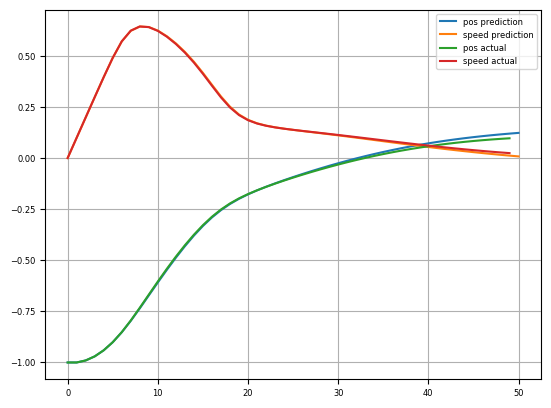

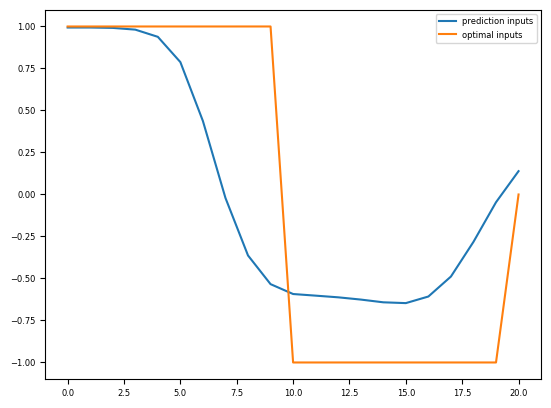

(Optimize Policy: Iter 1/12 - Loss: 4.416 )
(Optimize Policy: Iter 2/12 - Loss: 4.409 )
(Optimize Policy: Iter 3/12 - Loss: 4.402 )
(Optimize Policy: Iter 4/12 - Loss: 4.404 )
(Optimize Policy: Iter 5/12 - Loss: 4.974 )
(Optimize Policy: Iter 6/12 - Loss: 22.166 )
(Optimize Policy: Iter 7/12 - Loss: 18.406 )
(Optimize Policy: Iter 8/12 - Loss: 40.634 )
(Optimize Policy: Iter 9/12 - Loss: 7.140 )
(Optimize Policy: Iter 10/12 - Loss: 9.849 )
(Optimize Policy: Iter 11/12 - Loss: 21.864 )
(Optimize Policy: Iter 12/12 - Loss: 18.250 )


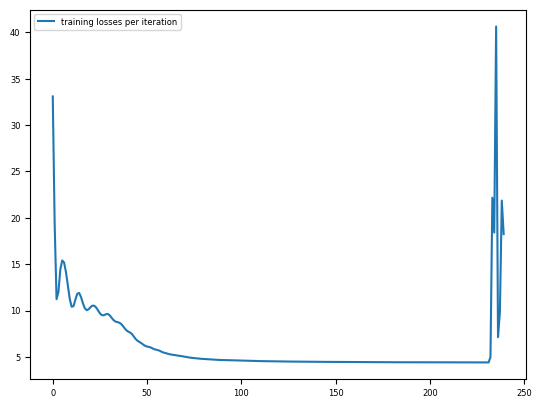

Iteration  2


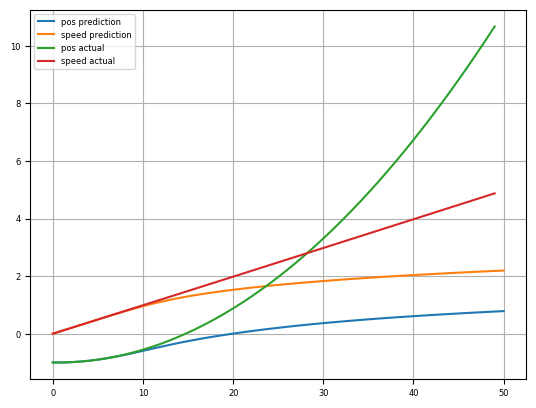

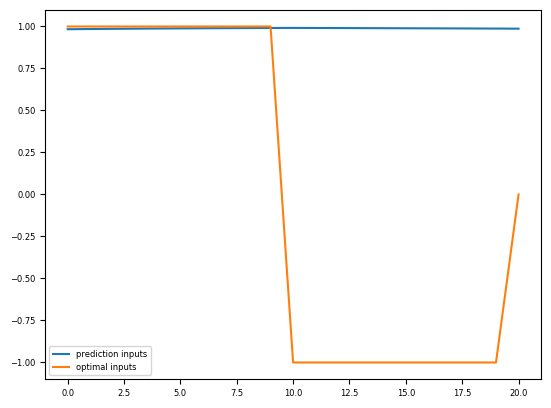

(Optimize Policy: Iter 1/12 - Loss: 18.149 )
(Optimize Policy: Iter 2/12 - Loss: 18.162 )
(Optimize Policy: Iter 3/12 - Loss: 18.196 )


KeyboardInterrupt: 

In [30]:
num_episodes = 5
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-1, 0, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
pilco.optim_lr = 5e-1
pilco.gamma = 0.99
# losses = []
for _ in range(num_episodes+1):
    print("Iteration ",(_+1))
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    # pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()
    
    plt.plot(pilco.controller(x).detach(),label='prediction inputs')
    plt.plot(y_values,label='optimal inputs')
    plt.legend()
    plt.show()

    # pilco.add(X,Y)
    # pilco.train()

    # pilco.eps = eps.value(_) 
    # pilco.optim_lr = lr.value(_)
    # pilco.explore = exp.value(_)
    trn_losses = pilco.optimize_policy()
    losses += trn_losses

    plt.plot(losses,label="training losses per iteration")
    plt.legend()
    plt.show()

# Comparing with optimal bang bang controller

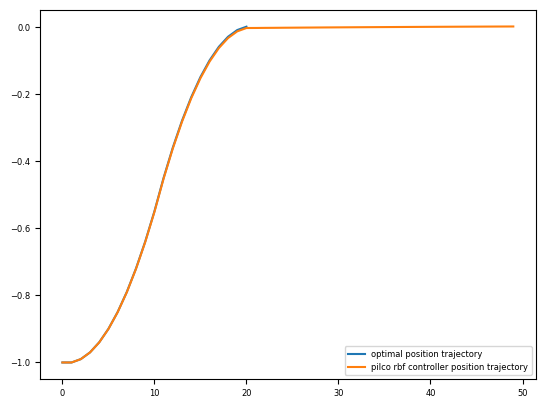

In [20]:
plt.plot(x[:,0],label="optimal position trajectory")
plt.plot(pos_env,label='pilco rbf controller position trajectory')
plt.legend()

C:\Users\RushiS\AppData\Local\Temp\ipykernel_21800\638831587.py:17: RuntimeWarning: divide by zero encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)
C:\Users\RushiS\AppData\Local\Temp\ipykernel_21800\638831587.py:17: RuntimeWarning: invalid value encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)


Iteration  1


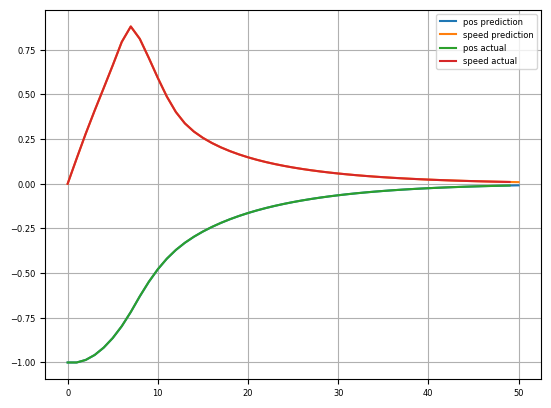

(Optimize Policy: Iter 1/12 - Loss: 4.928 )
(Optimize Policy: Iter 2/12 - Loss: 4.912 )
(Optimize Policy: Iter 3/12 - Loss: 4.907 )
(Optimize Policy: Iter 4/12 - Loss: 4.914 )
(Optimize Policy: Iter 5/12 - Loss: 4.921 )
(Optimize Policy: Iter 6/12 - Loss: 4.923 )
(Optimize Policy: Iter 7/12 - Loss: 4.922 )
(Optimize Policy: Iter 8/12 - Loss: 4.920 )
(Optimize Policy: Iter 9/12 - Loss: 4.918 )


KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt


num_episodes = 15
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-1, 0, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
pilco.optim_lr = 5e-2

for _ in range(num_episodes):
    print("Iteration ",(_+1))
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    # pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()

    pilco.add(X,Y)
    # pilco.train()
    # pilco.eps = eps.value(_) 
    # pilco.optim_lr = lr.value(_)
    # pilco.explore = exp.value(_)
    pilco.optimize_policy()

In [3]:
import matplotlib.pyplot as plt


num_episodes = 15
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-1, 0, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
pilco.optim_lr = 1e-2

for _ in range(num_episodes):
    print("Iteration ",(_+1))
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    # pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()

    # pilco.add(X,Y)
    # pilco.train()
    # pilco.eps = eps.value(_) 
    # pilco.optim_lr = lr.value(_)
    # pilco.explore = exp.value(_)
    pilco.optimize_policy()

NameError: name 'pilco' is not defined